In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import pickle
import copy
import warnings
from typing import Iterable, Union, Dict, List
warnings.filterwarnings('ignore')

In [2]:
Model = Union[
    SVC,
    LogisticRegression,
    KNeighborsClassifier,
    RandomForestClassifier,
    DecisionTreeClassifier,
]

In [3]:
# import files paths to data

TRAIN_FEATURES_FILENAME: str = r"D:\Obfuscation\data\datasets\divided\train_features.csv"
VALIDATE_FEATURES_FILENAME: str = r"D:\Obfuscation\data\datasets\divided\validate_features.csv"
TEST_FEATURES_FILENAME: str = r"D:\Obfuscation\data\datasets\divided\test_features.csv"
            
TRAIN_LABELS_FILENAME: str = r"D:\Obfuscation\data\datasets\divided\train_labels.csv"
VALIDATE_LABELS_FILENAME: str = r"D:\Obfuscation\data\datasets\divided\validate_labels.csv"
TEST_LABELS_FILENAME: str = r"D:\Obfuscation\data\datasets\divided\test_labels.csv"

In [4]:
# import train, validate and test data

train_features: pd.DataFrame = pd.read_csv(TRAIN_FEATURES_FILENAME)
train_labels: pd.Series = pd.read_csv(TRAIN_LABELS_FILENAME)
    
validate_features: pd.DataFrame = pd.read_csv(VALIDATE_FEATURES_FILENAME)
validate_labels: pd.Series = pd.read_csv(VALIDATE_LABELS_FILENAME)
    
test_features: pd.DataFrame = pd.read_csv(TEST_FEATURES_FILENAME)
test_labels: pd.Series = pd.read_csv(TEST_LABELS_FILENAME)

In [5]:
# Union common logic for each model's learning in one class

class ModelLearningPipeline:
    
    def __init__(self, model_class, hyperparameters: List[Dict[str, Iterable]], models_to_validation: int = 5) -> None:
        self.__model_class = model_class
        self.__hyperparameters: List[Dict[str, Iterable]] = hyperparameters
        self.__best_model: model_class = None
        self.__best_model_candidates: List[model_class] = [None] * models_to_validation
            
    def set_params(self, model_class, hyperparameters: List[Dict[str, Iterable]]) -> None:
        self.__model_class = model_class
        self.__hyperparameters = hyperparameters
        self.__best_model = None
        self.__best_model_candidates = [None] * len(self.__best_model_candidates)
   
    def cross_validate_initially(self, cv: int = 5) -> np.ndarray[float]:
        model: self.__model_class = self.__model_class()
        scores: np.ndarray[float] = cross_val_score(estimator=model, X=train_features, y=train_labels.values.ravel(), n_jobs=-1, cv=cv)
        return scores
    
    def tuning(self, show: bool = True, cv: int = 5, scoring: str = "accuracy") -> None:
        model: self.__model_class = self.__model_class()
        clf: GridSearchCV = GridSearchCV(estimator=model, param_grid=self.__hyperparameters, cv=cv, n_jobs=-1, scoring=scoring, verbose=2)
        clf.fit(train_features, train_labels.values.ravel())
        
        means: np.ndarray[float] = clf.cv_results_["mean_test_score"]
        stds: np.ndarray[float] = clf.cv_results_["std_test_score"]
        params_combinatons: np.ndarray[Dict[str, Union[str, int, float]]] = clf.cv_results_["params"]
        
        i: int = 0
        for mean, std, params in sorted(zip(means, stds, params_combinatons), key=lambda values: 1 - values[0] + values[1]):  # sorted from high to low scores
            if np.isnan(mean):
                continue
            if i >= len(self.__best_model_candidates):
                break
            model: self.__model_class = self.__model_class(**params)
            model.fit(train_features, train_labels.values.ravel())
            self.__best_model_candidates[i] = model
            i += 1
        
        if show:
            self.__show_tuning_result(means=means, stds=stds, params_combinatons=params_combinatons)
            
    def validate(self, show: bool = True) -> None:
        if not self.__exist_all_candidates():
            return
        
        accuracy_scores: List[float] = [0.0] * len(self.__best_model_candidates)  # true predictions (TP + TN) / all predictions (TP + TN + FP + FN)
        precision_scores: List[float] = copy.copy(accuracy_scores)  # true positive predictions (TP) / all positive predictions (TP + FP)
        recall_scores: List[float] = copy.copy(accuracy_scores)  # true positive predictions (TP) / all positive labels (TP + FN)
        
        for i, candidate_model in enumerate(self.__best_model_candidates):
            scores: Dict[str, float] = self.__score_metrics(model=candidate_model, features=validate_features, y_true=validate_labels)
            accuracy_scores[i] = scores.get("accuracy", None)
            precision_scores[i] = scores.get("precision", None)
            recall_scores[i] = scores.get("recall", None)
            
        best_metrics_value: float = 0.
        
        for candidate_model, accuracy, precision, recall in zip(self.__best_model_candidates, accuracy_scores, precision_scores, recall_scores):
            if accuracy + precision + recall <= best_metrics_value:
                continue
            best_metrics_value = accuracy + precision + recall
            self.__best_model = candidate_model
        
        if show:
            self.__show_evaluated_result(models=self.__best_model_candidates, accuracy_scores=accuracy_scores, precision_scores=precision_scores, recall_scores=recall_scores)
            
    def test(self) -> None:
        if self.__best_model is None:
            print("For checking the scores of model on test data the model must be initialized!")
            return
        scores: Dict[str, float] = self.__score_metrics(model=self.__best_model, features=test_features, y_true=test_labels)
        accuracy: float = scores.get("accuracy", None)
        precision: float = scores.get("precision", None)
        recall: float = scores.get("recall", None)
        
        self.__show_evaluated_result(models=[self.__best_model], accuracy_scores=[accuracy], precision_scores=[precision], recall_scores=[recall])        
            
    @staticmethod
    def __score_metrics(model, features: pd.DataFrame, y_true: pd.Series) -> Dict[str, float]:
        result: Dict[str, float] = {}
        y_pred: np.ndarray = model.predict(features)
        
        result["accuracy"] = np.round(accuracy_score(y_true=y_true, y_pred=y_pred), 5)
        result["precision"] = np.round(precision_score(y_true=y_true, y_pred=y_pred), 5)
        result["recall"] = np.round(recall_score(y_true=y_true, y_pred=y_pred), 5)
        
        return result
    
    @staticmethod
    def __show_tuning_result(means: np.ndarray[float], stds: np.ndarray[float], params_combinatons: np.ndarray[Dict[str, Union[int, float, str]]]) -> None:
        print("Tuning Result:\n")
        for mean, std, params in sorted(zip(means, stds, params_combinatons), key=lambda values: 1 - values[0] + values[1]):
            if np.isnan(mean):
                continue
            print(f"Mean: {np.round(mean, 5)} || Standard deviation: {np.round(std, 5)} || Hyperparameters: {params}\n")
    
    @staticmethod
    def __show_evaluated_result(models, accuracy_scores: List[float], precision_scores: List[float], recall_scores: List[float]) -> None:
        print(f"Evaluated Result:\n")
        
        if not (len(models) == len(accuracy_scores) == len(precision_scores) == len(recall_scores)):
            print("Size of input data is incorrect!")
            return
        
        for model, accuracy, precision, recall in zip(models, accuracy_scores, precision_scores, recall_scores):
            print(f"Model: {model} || Accuracy: {accuracy} || Precision: {precision} || Recall: {recall}\n")
    
    def __exist_all_candidates(self) -> bool:
        for candidate_model in self.__best_model_candidates:
            if candidate_model is None:
                return False
        return True
    
    def save(self, pkl_filename: str) -> bool:
        if self.__best_model is None:
            print("For save the model must be initialized!")
            return False
        
        try:
            with open(pkl_filename, 'wb') as file:
                pickle.dump(self.__best_model, file=file)
        except:
            return False
        return True

In [6]:
def calculate_hyperparams_combinations_quantity(hyperparams_list: List[Dict[str, Iterable]]) -> int:
    result: int = 0
    for hyperparams in hyperparams_list:
        current_hyperparams_combinations: int = 1
        for value in hyperparams.values():
            current_hyperparams_combinations *= len(value)
        result += current_hyperparams_combinations
    return result

In [7]:
def process_model(model_class, hyperparameters: List[Dict[str, Iterable]], filename_to_save: str, models_to_validation: int = 5) -> None:
    learning_pipeline: ModelLearningPipeline = ModelLearningPipeline(
        model_class=model_class,
        hyperparameters=hyperparameters,
        models_to_validation=min(models_to_validation, calculate_hyperparams_combinations_quantity(hyperparams_list=hyperparameters))
    )
    
    initial_scores: np.ndarray = learning_pipeline.cross_validate_initially()
    print(f"Scores from initial cross validation: {initial_scores},\nmean value = {initial_scores.mean()}.")
    
    learning_pipeline.tuning()
    learning_pipeline.validate()
    learning_pipeline.test()
    
    learning_pipeline.save(pkl_filename=filename_to_save)

## Logistic Regression

In [20]:
hyperparams: List[Dict[str, Iterable]] = [
    {
        'solver': ["lbfgs", "sag", "liblinear"],
        'penalty': ['l1', 'l2'],
        'C': np.logspace(-3, 3, 7),
        'n_jobs': [-1],
        'multi_class': ["ovr"],
        "max_iter": [1000],
    }   
]
    
logreg_filename: str = r"D:\Obfuscation\models\LogisticRegression_model.pkl"

In [ ]:
process_model(model_class=LogisticRegression, hyperparameters=hyperparams, filename_to_save=logreg_filename)

## KNN

In [21]:
hyperparams: List[Dict[str, Iterable]] = [
    {
        "n_neighbors": [5,7,9,11,13,15],
        'weights': ["uniform", "distance"],
        'metric': ['minkowski', 'euclidean', 'manhattan'],
        'n_jobs': [-1],
    }
]
    
knn_filename: str = r"D:\Obfuscation\models\KNearestNeighbors_model.pkl"

In [ ]:
process_model(model_class=KNeighborsClassifier, hyperparameters=hyperparams, filename_to_save=knn_filename)

## SVM

In [22]:
hyperparams: List[Dict[str, Iterable]] = [
    {
        'C': np.logspace(-3, 3, 7), 
        'kernel': ['linear']
    },
    {
        'C': np.logspace(-3, 3, 7), 
        'kernel': ['rbf'],
        'gamma': np.linspace(0.1, 0.9, 9)
    },
    {
        'C': np.logspace(-3, 3, 7), 
        'kernel': ['poly'],
        'degree': [2, 3, 4],
        'gamma': np.linspace(0.01, 0.05, 5)
    },
]
    
svm_filename: str = r"D:\Obfuscation\models\SupportVectorMachines_model.pkl"

In [ ]:
process_model(model_class=SVC, hyperparameters=hyperparams, filename_to_save=svm_filename)

## RF Classifier

In [23]:
n_estimators: List[int] = [10] + [int(value) for value in np.linspace(100, 500, 5)]
max_depth: List[int] = [int(x) for x in np.linspace(10, 90, 9)]
max_depth.append(None)
min_samples_leaf: List[int] = [1, 2, 4]
min_samples_split: List[int] = [2, 5, 10]

    

hyperparams: List[Dict[str, Iterable]] = [
    {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_leaf': min_samples_leaf,
        'min_samples_split': min_samples_split,
        'n_jobs': [-1],
    },
]
    
rf_filename: str = r"D:\Obfuscation\models\RandomForestClassifier_model.pkl"

In [18]:
process_model(model_class=RandomForestClassifier, hyperparameters=hyperparams, filename_to_save=rf_filename)

Scores from initial cross validation: [0.98990683 0.97902098 0.98834499 0.98912199 0.99067599],
mean value = 0.9874141558924168.
Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Tuning Result:

Mean: 0.99052 || Standard deviation: 0.00193 || Hyperparameters: {'max_depth': 50, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1}

Mean: 0.99068 || Standard deviation: 0.00214 || Hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 400, 'n_jobs': -1}

Mean: 0.99006 || Standard deviation: 0.00166 || Hyperparameters: {'max_depth': 80, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1}

Mean: 0.99068 || Standard deviation: 0.00231 || Hyperparameters: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 500, 'n_jobs': -1}

Mean: 0.99037 || Standard deviation: 0.002 || Hyperparameters: {'max_depth': 80, 'min_samples_leaf': 2, 'min_samples_spli

Evaluated Result:

Model: RandomForestClassifier(max_depth=50, min_samples_leaf=4, min_samples_split=10,
                       n_jobs=-1) || Accuracy: 0.98462 || Precision: 0.98214 || Recall: 0.98678

Model: RandomForestClassifier(min_samples_leaf=2, min_samples_split=10,
                       n_estimators=400, n_jobs=-1) || Accuracy: 0.98322 || Precision: 0.97938 || Recall: 0.98678

Model: RandomForestClassifier(max_depth=80, min_samples_leaf=2, min_samples_split=10,
                       n_jobs=-1) || Accuracy: 0.98649 || Precision: 0.98131 || Recall: 0.9915

Model: RandomForestClassifier(max_depth=30, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=500, n_jobs=-1) || Accuracy: 0.98276 || Precision: 0.97936 || Recall: 0.98584

Model: RandomForestClassifier(max_depth=80, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=500, n_jobs=-1) || Accuracy: 0.98369 || Precision: 0.9785 || Recall: 0.98867

Evaluated Result:

Model: Ra

## DT Classifier

In [8]:
criterion: List[str] = ["gini", "entropy"]
max_depth: List[int] = [int(x) for x in np.linspace(10, 90, 9)]
max_depth.append(None)
min_samples_leaf: List[int] = [1, 2, 4]
min_samples_split: List[int] = [2, 5, 10]
    

hyperparams: List[Dict[str, Iterable]] = [
    {
        'criterion': criterion,
        'max_depth': max_depth,
        'min_samples_leaf': min_samples_leaf,
        'min_samples_split': min_samples_split,
    },
]
    
dt_filename: str = r"D:\Obfuscation\models\DecisionTreeClassifier_model.pkl"

In [9]:
process_model(model_class=DecisionTreeClassifier, hyperparameters=hyperparams, filename_to_save=dt_filename)

Scores from initial cross validation: [0.98835404 0.98679099 0.98989899 0.99378399 0.98601399],
mean value = 0.9889683987510075.
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Tuning Result:

Mean: 0.99177 || Standard deviation: 0.00167 || Hyperparameters: {'criterion': 'entropy', 'max_depth': 90, 'min_samples_leaf': 4, 'min_samples_split': 5}

Mean: 0.99161 || Standard deviation: 0.00166 || Hyperparameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2}

Mean: 0.99161 || Standard deviation: 0.0018 || Hyperparameters: {'criterion': 'entropy', 'max_depth': 60, 'min_samples_leaf': 4, 'min_samples_split': 2}

Mean: 0.99161 || Standard deviation: 0.0018 || Hyperparameters: {'criterion': 'entropy', 'max_depth': 80, 'min_samples_leaf': 4, 'min_samples_split': 5}

Mean: 0.9913 || Standard deviation: 0.00151 || Hyperparameters: {'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 4, 'min_samples_split': 2}

Mean: 0.99145 || Sta

Evaluated Result:

Model: DecisionTreeClassifier(criterion='entropy', max_depth=90, min_samples_leaf=4,
                       min_samples_split=5) || Accuracy: 0.99208 || Precision: 0.98966 || Recall: 0.99433

Model: DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=4) || Accuracy: 0.99254 || Precision: 0.98967 || Recall: 0.99528

Model: DecisionTreeClassifier(criterion='entropy', max_depth=60, min_samples_leaf=4) || Accuracy: 0.99161 || Precision: 0.98965 || Recall: 0.99339

Model: DecisionTreeClassifier(criterion='entropy', max_depth=80, min_samples_leaf=4,
                       min_samples_split=5) || Accuracy: 0.99208 || Precision: 0.98966 || Recall: 0.99433

Model: DecisionTreeClassifier(criterion='entropy', max_depth=50, min_samples_leaf=4) || Accuracy: 0.99208 || Precision: 0.98966 || Recall: 0.99433

Evaluated Result:

Model: DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=4) || Accuracy: 0.99068 || Precision: 0.99437 || Rec

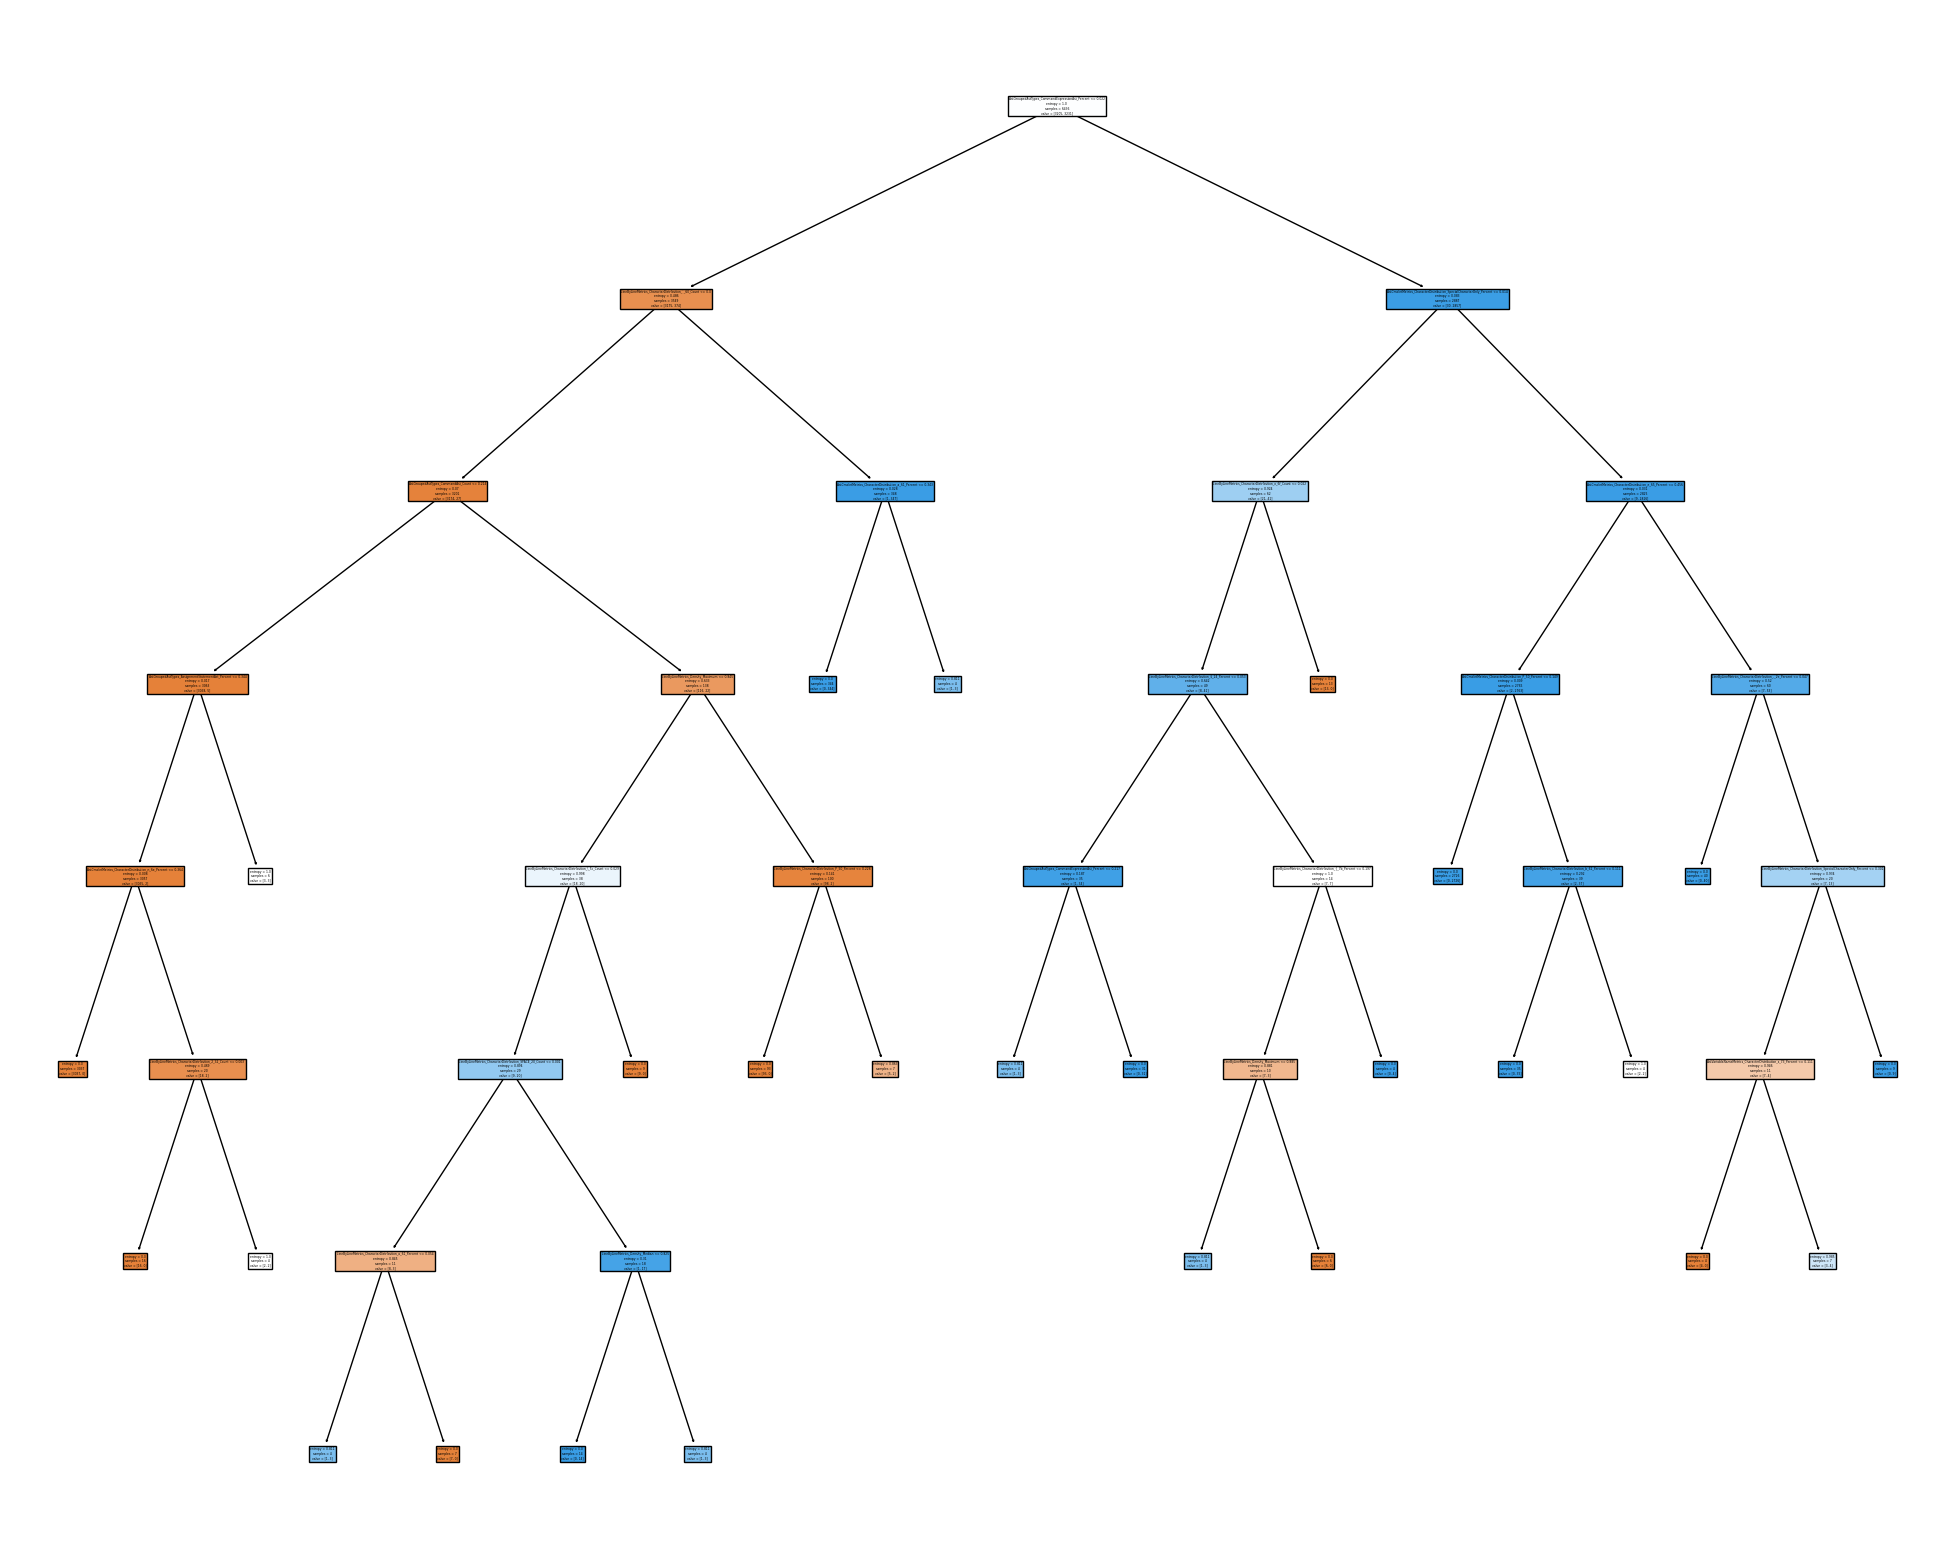

In [12]:
from sklearn import tree

fig = plt.figure(figsize=(25, 20))
dt_model: DecisionTreeClassifier = load_model(model_filename=dt_filename)
_ = tree.plot_tree(dt_model, feature_names=train_features.columns, filled=True)

In [17]:
text_representation = tree.export_text(dt_model, feature_names=list(train_features.columns))
print(text_representation)

|--- AstGroupedAstTypes_CommandExpressionAst_Percent <= 0.02
|   |--- LineByLineMetrics_CharacterDistribution_`_60_Count <= 0.00
|   |   |--- AstGroupedAstTypes_CommandAst_Count <= 0.21
|   |   |   |--- AstGroupedAstTypes_AssignmentStatementAst_Percent <= 0.34
|   |   |   |   |--- AstCmdletMetrics_CharacterDistribution_n_6e_Percent <= 0.36
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- AstCmdletMetrics_CharacterDistribution_n_6e_Percent >  0.36
|   |   |   |   |   |--- LineByLineMetrics_CharacterDistribution_2_32_Count <= 0.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- LineByLineMetrics_CharacterDistribution_2_32_Count >  0.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |--- AstGroupedAstTypes_AssignmentStatementAst_Percent >  0.34
|   |   |   |   |--- class: 0
|   |   |--- AstGroupedAstTypes_CommandAst_Count >  0.21
|   |   |   |--- LineByLineMetrics_Density_Maximum <= 0.85
|   |   |   |   |--- LineByLineMetrics_CharacterDistribution_\_5c_Count <= 0.0

### Checking Best model results using 5-fold Cross Validation on different parts of data

In [10]:
def load_model(model_filename: str, mode: str = "rb") -> Model:
    model: Model = None
    try:
        with open(model_filename, mode) as file:
            model = pickle.load(file)
        return model
    except Exception as e:
        print(f"The exception was occured while loading model from file {model_filename}: {e}.")

In [18]:
def check_model_scores(model: Model, cv: int = 5) -> None:
    train_scores: np.ndarray[float] = cross_val_score(estimator=model, X=train_features, y=train_labels.values.ravel(), n_jobs=-1, cv=cv)
    validate_scores: np.ndarray[float] = cross_val_score(estimator=model, X=validate_features, y=validate_labels.values.ravel(), n_jobs=-1, cv=cv)
    test_scores: np.ndarray[float] = cross_val_score(estimator=model, X=test_features, y=test_labels.values.ravel(), n_jobs=-1, cv=cv)

    print(f"Model {model}.\n")
    print(f"Train scores: {train_scores}.\nMean value in {cv}-Fold Cross Validation on train data = {train_scores.mean()}.\n")
    print(f"Validate scores: {validate_scores}.\nMean value in {cv}-Fold Cross Validation on validate data = {validate_scores.mean()}.\n")
    print(f"Test scores: {test_scores}.\nMean value in {cv}-Fold Cross Validation on test data = {test_scores.mean()}.\n")


In [24]:
models_filenames: List[str] = [
    logreg_filename,
    knn_filename,
    svm_filename,
    rf_filename,
    dt_filename,
]
    
models: List[Model] = [load_model(model_filename) for model_filename in models_filenames]
for model in models:
    check_model_scores(model)

Model LogisticRegression(C=0.1, max_iter=1000, multi_class='ovr', n_jobs=-1,
                   penalty='l1', solver='liblinear').

Train scores: [0.99145963 0.99067599 0.99145299 0.99222999 0.98989899].
Mean value in 5-Fold Cross Validation on train data = 0.9911435183174314.

Validate scores: [0.98372093 0.98135198 0.98135198 0.995338   0.97902098].
Mean value in 5-Fold Cross Validation on validate data = 0.984156773459099.

Test scores: [0.96511628 0.98135198 0.98368298 0.97902098 0.96270396].
Mean value in 5-Fold Cross Validation on test data = 0.9743752371659349.

Model KNeighborsClassifier(n_jobs=-1).

Train scores: [0.96661491 0.96581197 0.97513598 0.97202797 0.97202797].
Mean value in 5-Fold Cross Validation on train data = 0.9703237583672367.

Validate scores: [0.95581395 0.95337995 0.96270396 0.94871795 0.96503497].
Mean value in 5-Fold Cross Validation on validate data = 0.9571301566650403.

Test scores: [0.96046512 0.96270396 0.97902098 0.96270396 0.94638695].
Mean value in